In [117]:
import pandas as pd
import numpy as np

import requests
import json

import csv
import matplotlib.pyplot as plt
import seaborn as sns

import os

import datetime
import chess.pgn

import requests

In [114]:
""" the following code gets all the games played by the username (mentioned at the buttom).

def get_player_games(username):
    # Set the username and API endpoint
    username = username.lower()
    api_url = f"https://lichess.org/api/games/user/{username}"

    # Set the request headers
    headers = {
        "Accept": "application/x-chess-pgn"
    }

    try:
        # Send a GET request to the API endpoint
        response = requests.get(api_url, headers=headers)
        response.raise_for_status()  # Raise an exception if the request fails

        # Get the games data from the response
        games_data = response.text

        # Save the games data to a PGN file
        with open(f"{username}_games.pgn", "w", encoding="utf-8") as file:
            file.write(games_data)

        print(f"Successfully saved {username}'s games to {username}_games.pgn")

    except requests.exceptions.RequestException as e:
        print(f"Error retrieving {username}'s games:", str(e))

# Call the method with the desired username
get_player_games('nihalsarin2004')

"""


' the following code gets all the games played by the username (mentioned at the buttom).\n\ndef get_player_games(username):\n    # Set the username and API endpoint\n    username = username.lower()\n    api_url = f"https://lichess.org/api/games/user/{username}"\n\n    # Set the request headers\n    headers = {\n        "Accept": "application/x-chess-pgn"\n    }\n\n    try:\n        # Send a GET request to the API endpoint\n        response = requests.get(api_url, headers=headers)\n        response.raise_for_status()  # Raise an exception if the request fails\n\n        # Get the games data from the response\n        games_data = response.text\n\n        # Save the games data to a PGN file\n        with open(f"{username}_games.pgn", "w", encoding="utf-8") as file:\n            file.write(games_data)\n\n        print(f"Successfully saved {username}\'s games to {username}_games.pgn")\n\n    except requests.exceptions.RequestException as e:\n        print(f"Error retrieving {username}\'s 

In [118]:
def export_arena_tournament_games(tournament_id):
    # Set the API endpoint
    api_url = f"https://lichess.org/api/tournament/{tournament_id}/games"

    # Set the request headers
    headers = {
        "Accept": "application/x-chess-pgn"
    }

    try:
        # Send a GET request to the API endpoint
        response = requests.get(api_url, headers=headers)
        response.raise_for_status()  # Raise an exception if the request fails

        # Get the games data from the response
        games_data = response.text

        # Save the games data to a PGN file
        with open(f"tournament_{tournament_id}_games.pgn", "w", encoding="utf-8") as file:
            file.write(games_data)

        print(f"Successfully exported games of tournament {tournament_id} to tournament_{tournament_id}_games.pgn")

    except requests.exceptions.RequestException as e:
        print(f"Error exporting games of tournament {tournament_id}:", str(e))
        


In [116]:
tournament_id = "LbIBh1P5"  # Replace with recent tournament ID
export_arena_tournament_games(tournament_id)


KeyboardInterrupt: 

In [119]:
def append_pgn_to_existing(pgn_file):
    with open(pgn_file, "r", encoding="utf-8") as file:
        pgn_data = file.read()

    with open("games.pgn", "a", encoding="utf-8") as file:
        file.write(pgn_data)

    print(f"Successfully appended the content of {pgn_file} to games.pgn")

In [ ]:
append_pgn_to_existing("rottem_games.pgn") #enter arena id


In [120]:
def create_dataset_from_pgn(pgn_file):
    """
    Creates a dataset from a PGN file.

    Args:
        pgn_file (str): The path to the PGN file.

    Returns:
        pd.DataFrame: A pandas DataFrame representing the dataset.
    """
    games = []

    with open(pgn_file) as file:
        while True:
            try:
                game = chess.pgn.read_game(file)
            except:
                continue
                
            if game is None:
                break

            try:
                moves = [move.uci() for move in game.mainline_moves()]
                
                # Attempt to parse the moves and check for illegal moves
                board = chess.Board()
                for move in moves:
                    board.push_uci(move)
                
            except chess.IllegalMoveError:
                # Skip games with illegal moves
                continue
                
            # Extract desired information from the game
            player1 = game.headers.get('White', 'Unknown Player 1')
            player2 = game.headers.get('Black', 'Unknown Player 2')
            rating1 = game.headers.get('WhiteElo', '0')
            rating2 = game.headers.get('BlackElo', '0')
            moves = [move.uci() for move in game.mainline_moves()]
            opening = game.headers.get('ECO' , 'Other')
            outcome = game.headers.get('Result', '*')
            move_count = len(moves)
            
            if isinstance(rating1, str) and rating1.isdigit():
                rating1 = int(rating1)
            else:
                rating1 = 0

            if isinstance(rating2, str) and rating2.isdigit():
                rating2 = int(rating2)
            else:
                rating2 = 0


            # Create a dictionary representing the game
            game_data = {
                'White': player1,
                'Elo_White': rating1,
                'Black': player2,
                'Elo_Black': rating2,
                'Outcome': outcome,
                'ECO': opening,
                'Moves': moves,
                'Move_Count': move_count
            }

            games.append(game_data)

    # Convert the list of games into a pandas DataFrame
    dataset = pd.DataFrame(games)

    return dataset

In [121]:
pgn_file = 'games.pgn'
dataset = create_dataset_from_pgn(pgn_file)

# Display the dataset
print(dataset)

error during pgn parsing
Traceback (most recent call last):
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\__init__.py", line 3062, in parse_san
    raise IllegalMoveError(f"illegal san: {san!r} in {self.fen()}")
chess.IllegalMoveError: illegal san: 'd5' in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
error during pgn parsing
Traceback (most recent call last):
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1059, 

                        White  Elo_White                    Black  Elo_Black  \
0                           ?          0                        ?          0   
1                           ?          0                        ?          0   
2            Merkistein, Suni       1901  Apol, Luitjen Akselsson       2126   
3      Thorsteinsson, Sjurdur       2127     Dalsgard, Arnbjorn O       1881   
4                Joensen, Oli       1785           Hansen, Herluf       1971   
...                       ...        ...                      ...        ...   
49860               fierakike       1333                   rottem       1305   
49861                  rottem       1358               oualidlmt1       1451   
49862                  rottem       1453                  MarthaC       1425   
49863         Alex_Crackceres       1322                   rottem       1339   
49864               weetabixx       1531                   rottem       1500   

       Outcome    ECO                  

In [123]:
def handle_missing_values(df):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Remove rows or columns with missing values
    df = df.dropna(axis=0)  # Remove rows with missing values

    return df

In [124]:
def count_moves(moves):
    num_moves = len(moves)
    return num_moves

In [125]:
def drop_short_games(data):
    data['MoveCount'] = data['Moves'].apply(count_moves)
    filtered_data = data[data['MoveCount'] >= 10]
    filtered_data = filtered_data.drop('MoveCount', axis=1)
    return filtered_data

In [126]:
def clean_data(df):
    # Drop games with missing player ratings
    df = df.dropna(subset=['Elo_White', 'Elo_Black'])
    
    # Check for large values in Elo columns
    max_elo = 3000  # Set a reasonable maximum Elo rating
    df = df[(df['Elo_White'] <= max_elo) & (df['Elo_Black'] <= max_elo)]

    # Remove irrelevant columns
    df = df.drop(['White', 'Black'], axis=1)
    df = df[df['ECO'] != 'Other']
    df = df[df['ECO'] != '?']
    return df

In [127]:
# Clean the data
cleaned_data = clean_data(dataset)

# Handle missing values
processed_data = handle_missing_values(cleaned_data)

print(processed_data)

       Elo_White  Elo_Black Outcome  ECO  \
2           1901       2126     1-0  E62   
3           2127       1881     1-0  A43   
4           1785       1971     0-1  E14   
5           2193       2026     1-0  C52   
6           1990       2061     0-1  B09   
...          ...        ...     ...  ...   
49860       1333       1305     1-0  C20   
49861       1358       1451     0-1  C50   
49862       1453       1425     0-1  C55   
49863       1322       1339     0-1  C23   
49864       1531       1500     1-0  C47   

                                                   Moves  Move_Count  
2      [g1f3, g8f6, c2c4, g7g6, g2g3, f8g7, f1g2, e8g...          93  
3      [d2d4, e7e6, c2c4, c7c5, d4d5, e6d5, c4d5, d7d...          51  
4      [d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, e2e3, c8b...          86  
5      [e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, b2b4, c5b...         109  
6      [e2e4, d7d6, d2d4, g8f6, b1c3, g7g6, f2f4, f8g...          62  
...                                          

In [128]:
opening_dict = {
    'A00-A39': 'Irregular Openings',
    'A40-A41': 'Queen\'s Pawn',
    'A42': 'Modern Defense',
    'A43-A44': 'Old Benoni Defense',
    'A45-A46': 'Queen\'s Pawn Game',
    'A47': 'Queen\'s Indian Defense',
    'A48-A49': 'King\'s Indian, East Indian Defense',
    'A50': 'Queen\'s Pawn Game',
    'A51-A52': 'Budapest Defense',
    'A53-A55': 'Old Indian Defense',
    'A56': 'Benoni Defense',
    'A57-A59': 'Benko Gambit',
    'A60-A79': 'Benoni Defense',
    'A80-A99': 'Dutch Defense',
    'B00': 'King\'s Pawn',
    'B01': 'Scandinavian Defense',
    'B02-B05': 'Alekhine\'s Defense',
    'B06': 'Robatsch Defense',
    'B07-B09': 'Pirc Defense',
    'B10-B19': 'Caro-Kann Defense',
    'B20-B99': 'Sicilian Defense',
    'C00-C19': 'French Defense',
    'C20': 'King\'s Pawn Game',
    'C21-C22': 'Center Game',
    'C23-C24': 'Bishop\'s Opening',
    'C25-C29': 'Vienna Game',
    'C30-C39': 'King\'s Gambit',
    'C40': 'King\'s Knight Opening',
    'C41': 'Philidor\'s Defense',
    'C42-C43': 'Petrov\'s Defense',
    'C44': 'King\'s Pawn Game',
    'C45': 'Scotch Game',
    'C46': 'Three Knights Game',
    'C47-C49': 'Four Knights',
    'C50': 'Italian Game',
    'C51-C52': 'Evans Gambit',
    'C53-C54': 'Giuoco Piano',
    'C55-C59': 'Two Knights Defense',
    'C60-C99': 'Ruy Lopez (Spanish Opening)',
    'D00': 'Queen\'s Pawn Game',
    'D01': 'Richter-Veresov Attack',
    'D02': 'Queen\'s Pawn Game',
    'D03': 'Torre Attack',
    'D04-D05': 'Queen\'s Pawn Game',
    'D06': 'Queen\'s Gambit',
    'D07-D09': 'Queen\'s Gambit Declined',
    'D10-D15': 'Queen\'s Gambit Declined Slav Defense',
    'D16': 'Queen\'s Gambit Declined Slav Accepted',
    'D17-D19': 'Queen\'s Gambit Declined Slav, Czech Defense',
    'D20-D29': 'Queen\'s Gambit Accepted',
    'D30-D42': 'Queen\'s Gambit Declined',
    'D43-D49': 'Queen\'s Gambit Declined Semi-Slav Defense',
    'D50-D69': 'Queen\'s Gambit Declined',
    'D70-D79': 'Neo-Gruenfeld Defense',
    'D80-D99': 'Gruenfeld Defense',
    'E00': 'Queen\'s Pawn Game',
    'E01-E09': 'Catalan Opening',
    'E10-E19': 'Queen\'s Pawn Game',
    'E20-E59': 'Nimzo-Indian Defense',
    'E60-E99': 'King\'s Indian Defense'
}

In [129]:
def opening_name(opening):
    opening_name = None
    for eco_range, opening_value in opening_dict.items():
        if '-' in eco_range:
            range_start, range_end = eco_range.split('-')
            if opening >= range_start and opening <= range_end:
                opening_name = opening_value
                break
        else:
            if opening == eco_range:
                opening_name = opening_value
                break
    return opening_name


In [130]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_popular_openings(data):
    # Group the data by ECO code and count the number of occurrences
    opening_counts = data['ECO'].value_counts().nlargest(10)

    # Extract the ECO codes and their corresponding counts
    eco_codes = opening_counts.index.tolist()
    game_counts = opening_counts.values.tolist()

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(eco_codes, game_counts)

    # Set the plot title and labels
    plt.title('Top 10 Most Popular Openings by ECO Code')
    plt.xlabel('ECO Code')
    plt.ylabel('Number of Games Played')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()
    return eco_codes


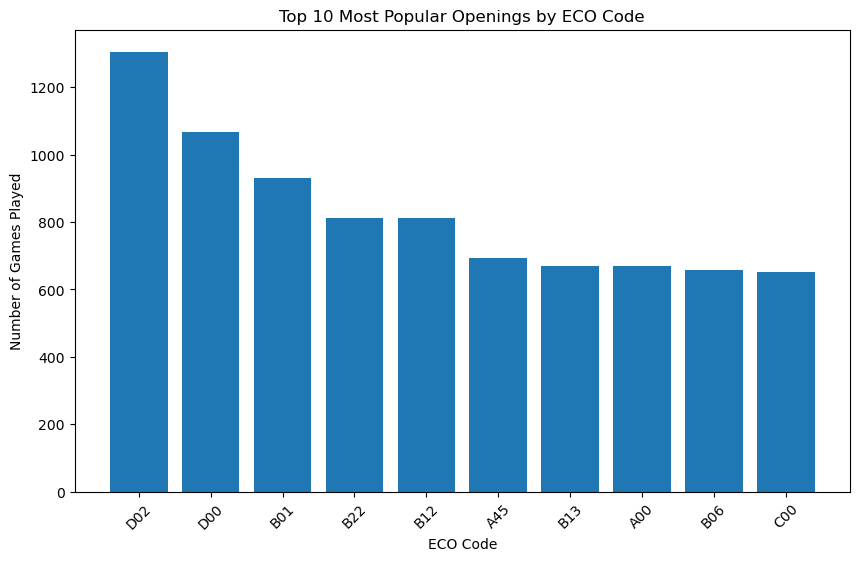

In [131]:
popular_eco_codes = plot_popular_openings(processed_data)

In [132]:
def filter_games_by_rating_range(min_rating, max_rating, dataset):
    """
    Filters games from the dataset based on the specified rating range.

    Args:
        min_rating (int): The minimum rating of the range.
        max_rating (int): The maximum rating of the range.
        dataset (pd.DataFrame): The dataset containing the games.

    Returns:
        pd.DataFrame: The filtered dataset.
    """
    filtered_dataset = dataset[
        (dataset['Elo_White'] >= min_rating) & (dataset['Elo_White'] <= max_rating) &
        (dataset['Elo_Black'] >= min_rating) & (dataset['Elo_Black'] <= max_rating)
    ]

    return filtered_dataset

In [133]:
def filter_games_by_opening(opening, dataset):
    # Filter the dataset by the opening
    filtered_dataset = dataset[dataset['ECO'] == opening]

    return filtered_dataset

In [134]:
def plot_opening_by_rating(opening, dataset):
    # Initialize empty lists for ratings and frequencies
    ratings = []
    frequencies = []

    # Iterate through rating ranges starting from 1000 with 300 points in each range until 3000
    for min_rating in range(1000, 3001, 300):
        max_rating = min_rating + 299

        # Filter the dataset by rating range
        filtered_games = filter_games_by_rating_range(min_rating, max_rating, dataset)
       
        # Filter the dataset by the opening
        filtered_dataset = filter_games_by_opening(opening, filtered_games)


        # Calculate the frequency of the opening in the rating range
        frequency = len(filtered_dataset)

        # Append the rating and frequency to the lists
        ratings.append(f"{min_rating}-{max_rating}")
        frequencies.append(frequency)

    # Create the bar chart
    plt.bar(ratings, frequencies)
    plt.xlabel("Rating Range")
    plt.ylabel("Times Played")
    plt.title(f"Opening : "+ opening + " " + opening_name(opening))
    plt.xticks(rotation=45)
    plt.show()

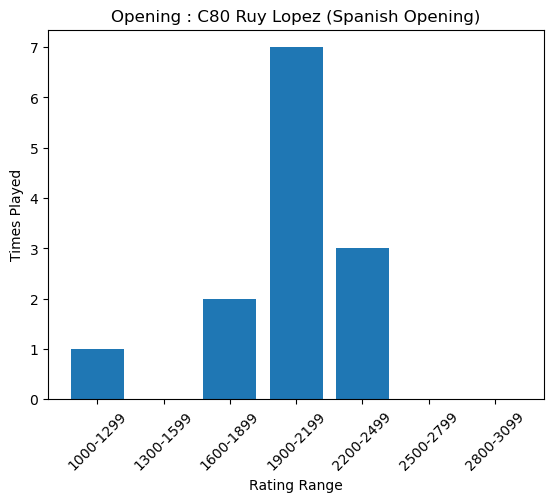

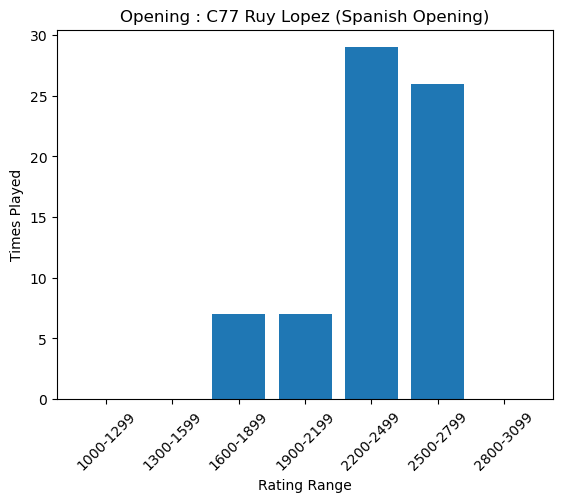

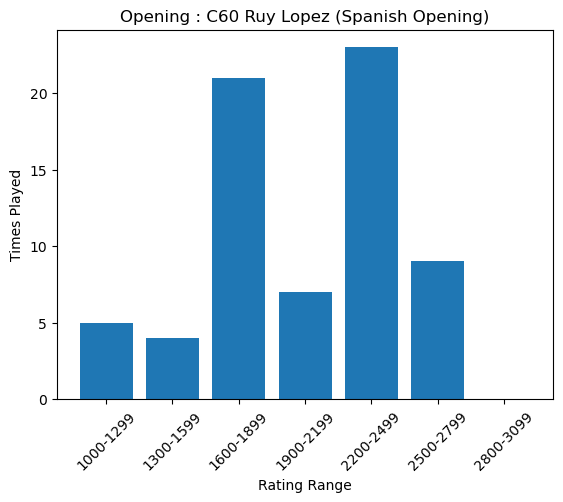

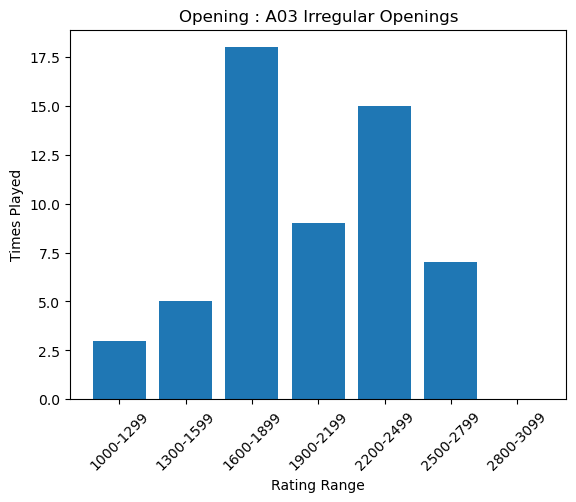

In [135]:
plot_opening_by_rating('C80' , processed_data)
plot_opening_by_rating('C77' , processed_data)
plot_opening_by_rating('C60' , processed_data)
plot_opening_by_rating('A03' , processed_data)


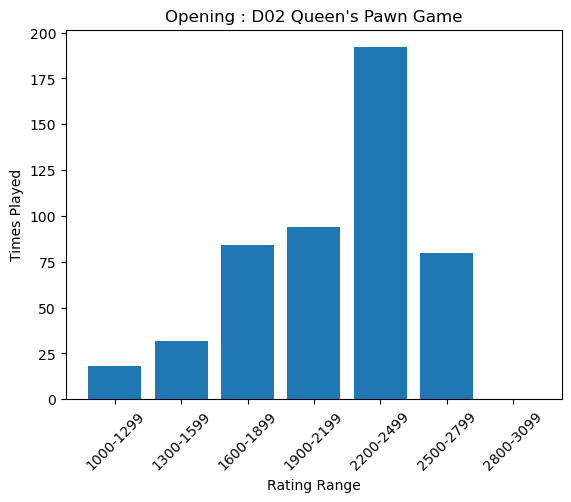

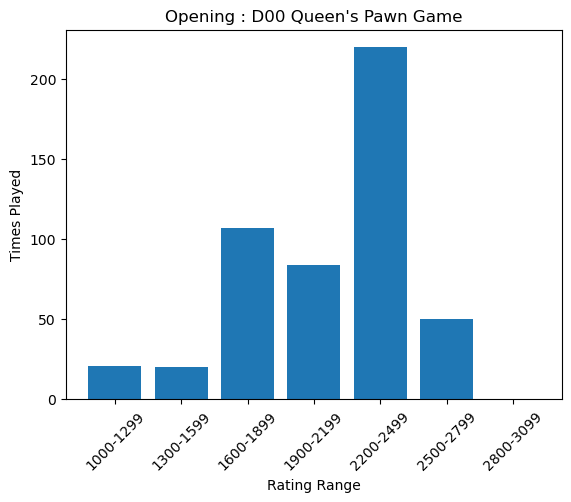

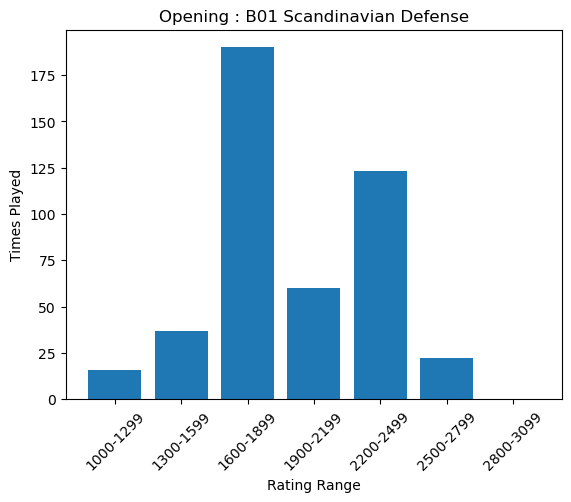

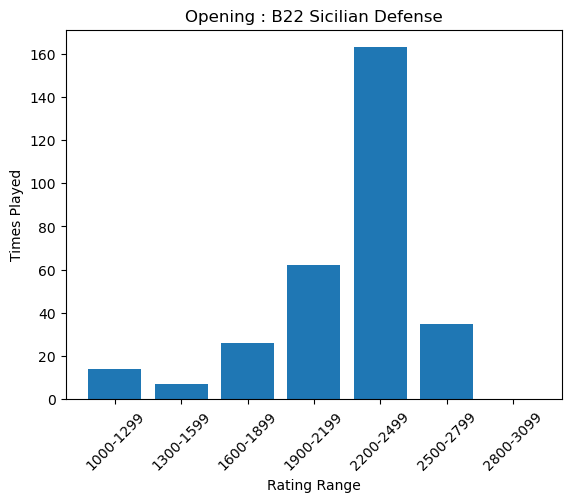

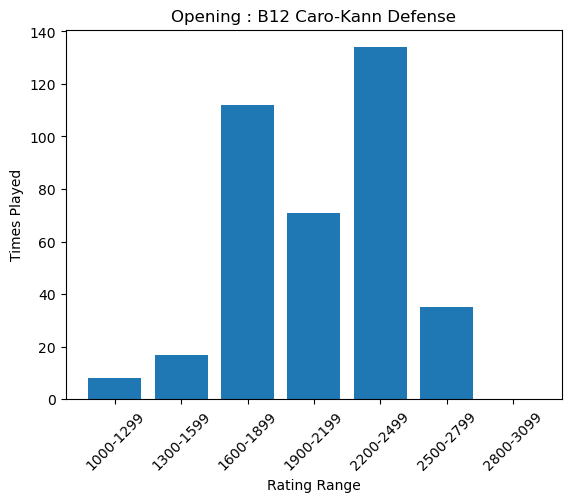

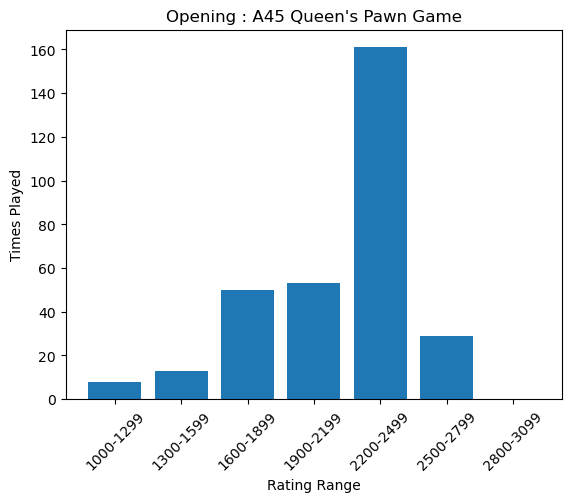

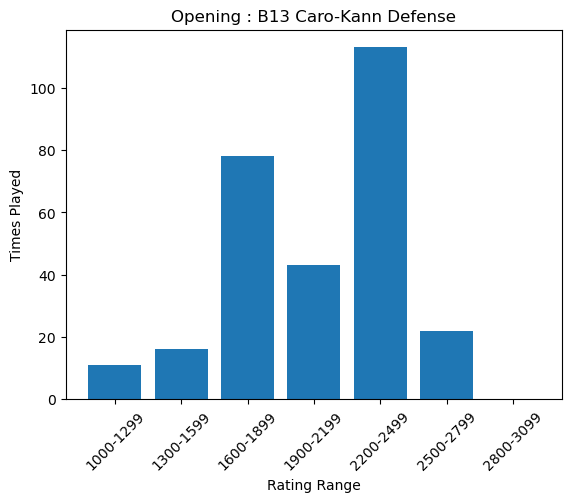

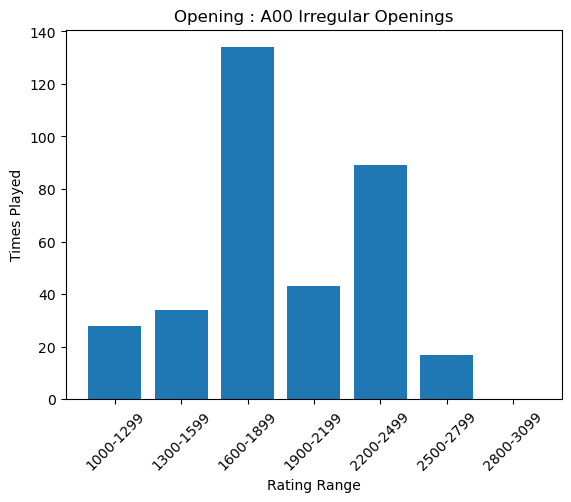

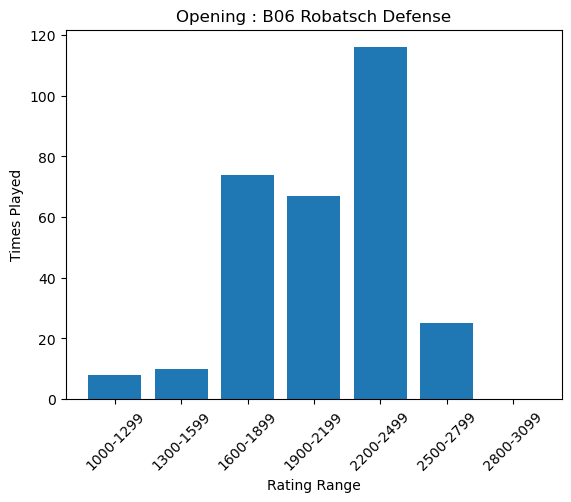

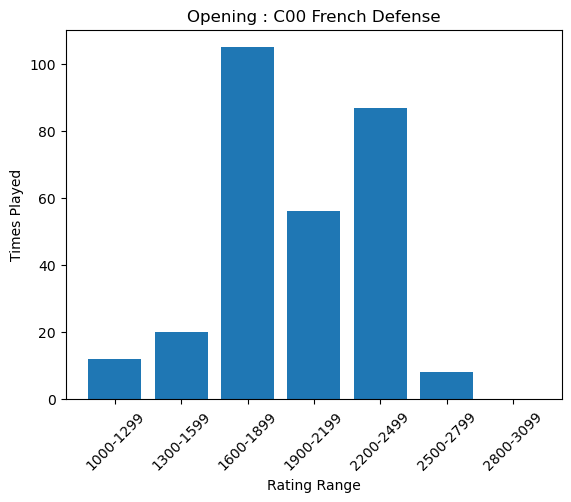

In [136]:
for opening in popular_eco_codes:
    plot_opening_by_rating(opening , processed_data)
    

In [137]:
def create_opening_pie_chart(opening, dataset):
    filtered_games = dataset[dataset['ECO'] == opening]
    total_games = len(filtered_games)
    
    if total_games == 0:
        print(f"No games found for opening: {opening}")
        return
            
    win_count = len(filtered_games[filtered_games['Outcome'] == '1-0'])
    lose_count = len(filtered_games[filtered_games['Outcome'] == '0-1'])
    draw_count = len(filtered_games[filtered_games['Outcome'] == '1/2-1/2'])

    win_percentage = (win_count / total_games) * 100
    lose_percentage = (lose_count / total_games) * 100
    draw_percentage = (draw_count / total_games) * 100

    labels = ['Win', 'Lose', 'Draw']
    sizes = [win_percentage, lose_percentage, draw_percentage]
    colors = ['green', 'red', 'yellow']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(f"Opening:"+ opening + " " + opening_name(opening) + "- Games Played:" + str(total_games))
    plt.show()


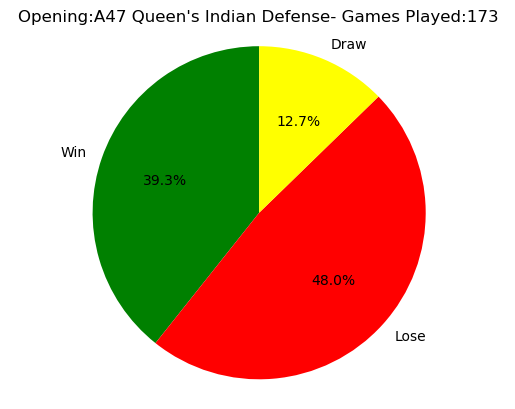

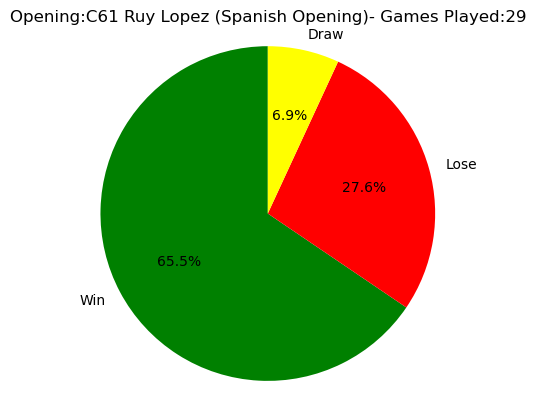

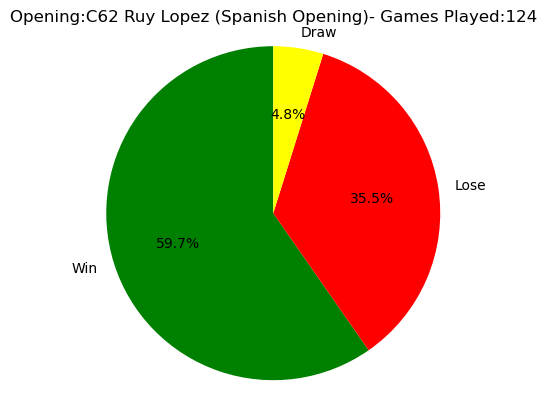

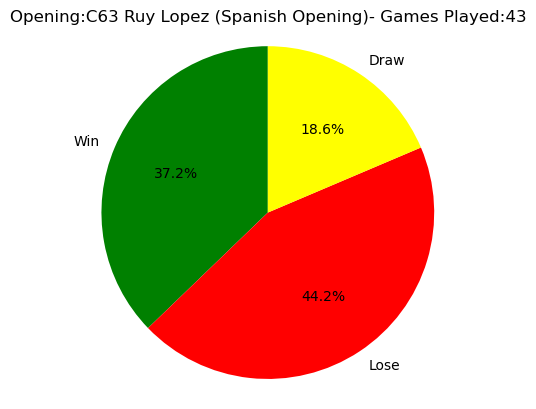

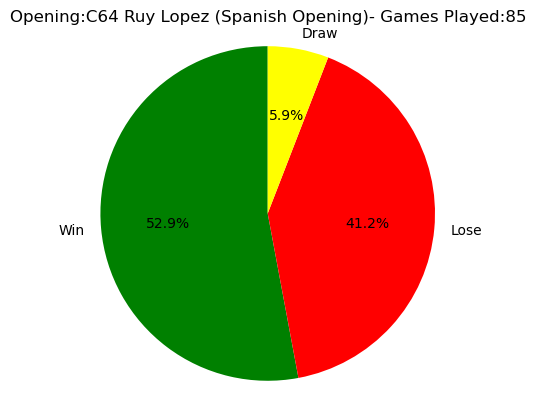

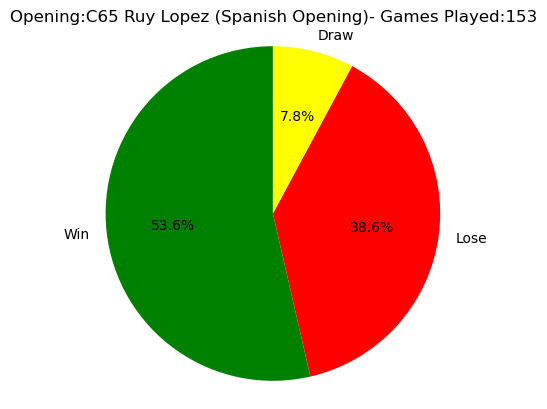

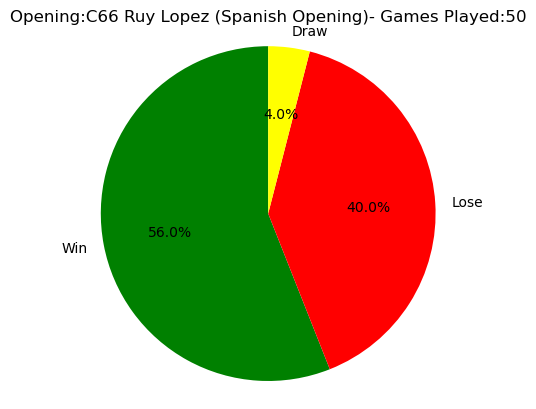

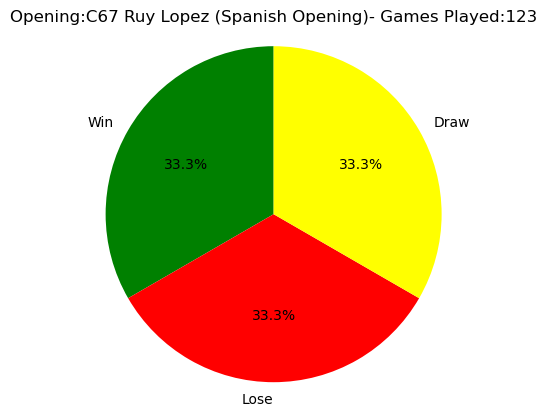

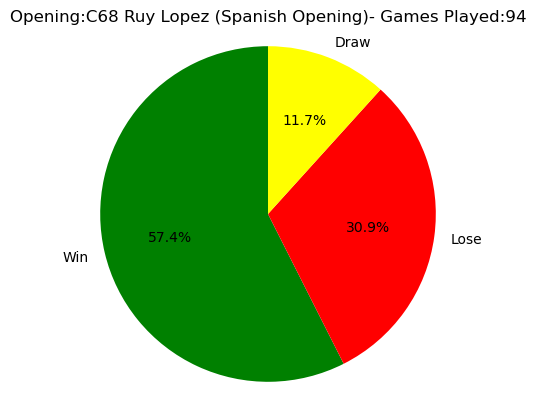

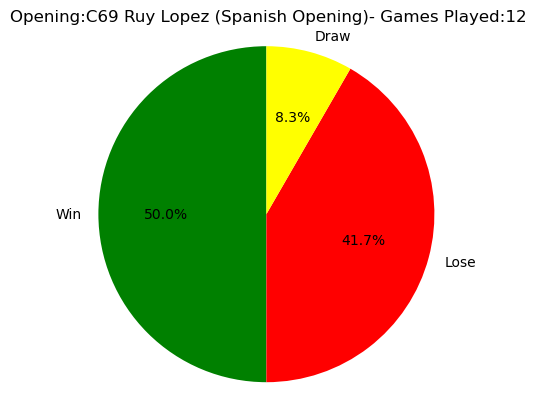

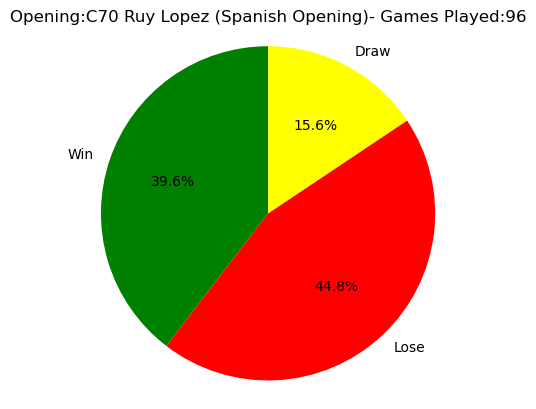

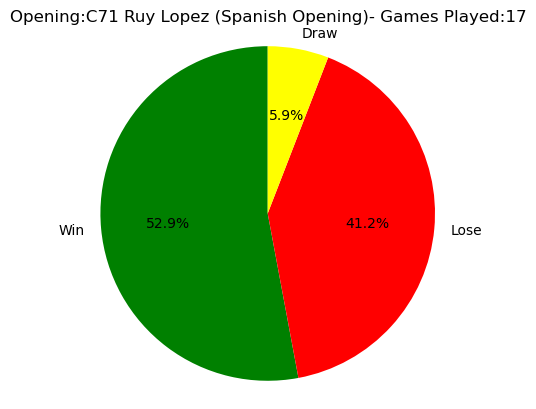

In [138]:
create_opening_pie_chart('A47', processed_data)
create_opening_pie_chart('C61', processed_data)
create_opening_pie_chart('C62', processed_data)
create_opening_pie_chart('C63', processed_data)
create_opening_pie_chart('C64', processed_data)
create_opening_pie_chart('C65', processed_data)
create_opening_pie_chart('C66', processed_data)
create_opening_pie_chart('C67', processed_data)
create_opening_pie_chart('C68', processed_data)
create_opening_pie_chart('C69', processed_data)
create_opening_pie_chart('C70', processed_data)
create_opening_pie_chart('C71', processed_data)



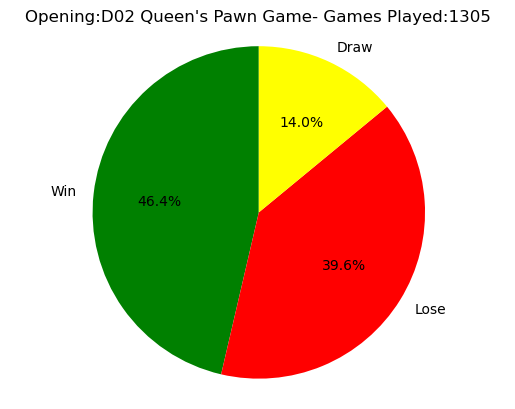

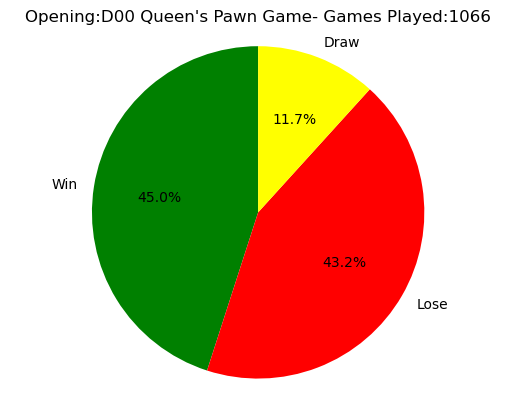

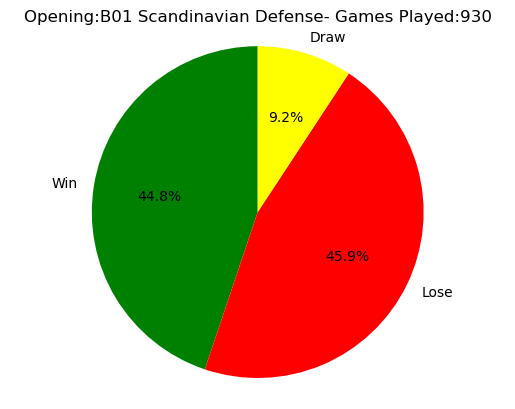

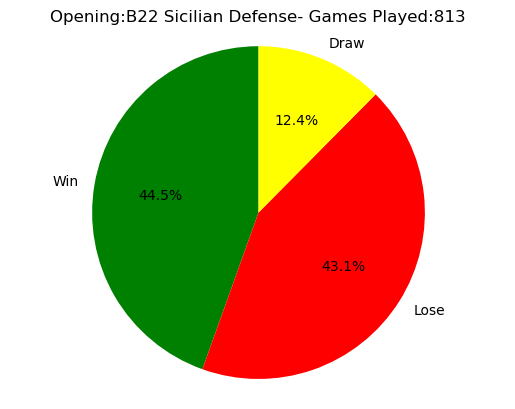

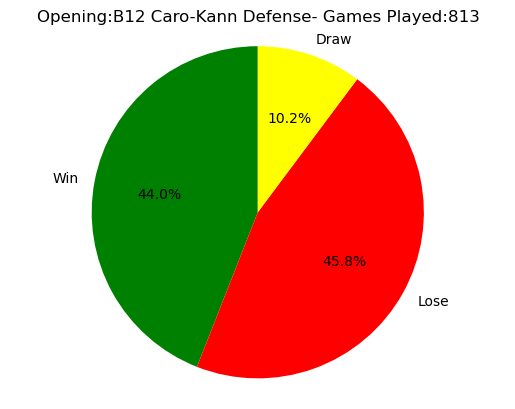

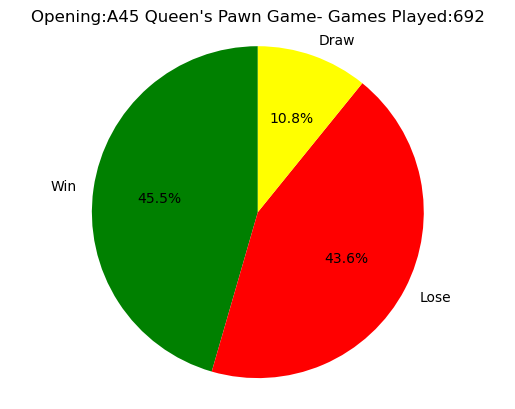

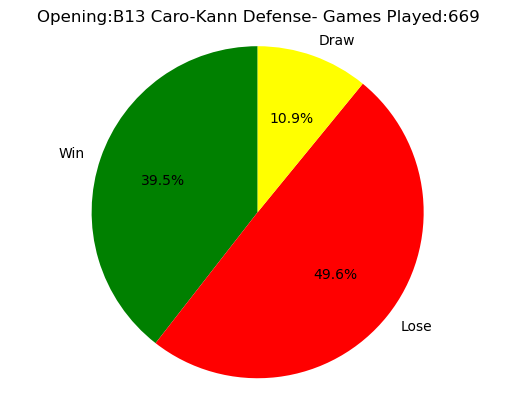

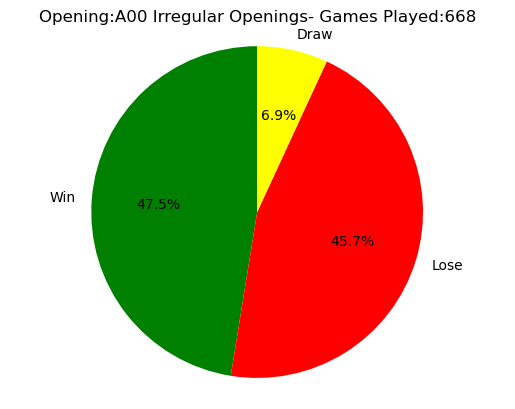

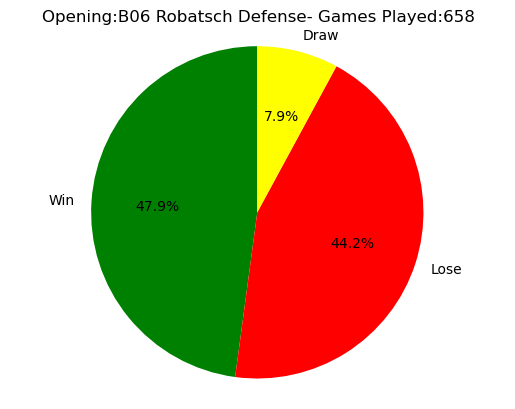

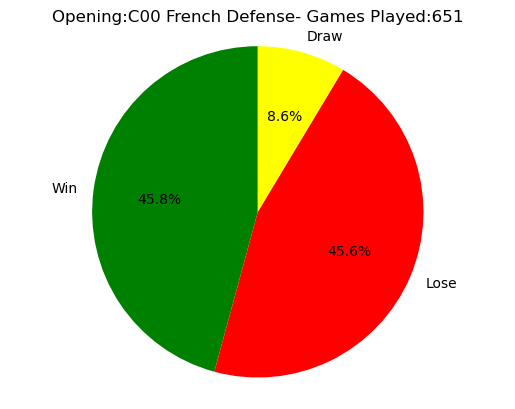

In [139]:
for opening in popular_eco_codes:
    create_opening_pie_chart(opening , processed_data)

In [140]:
import matplotlib.pyplot as plt

def plot_rating_vs_win_percentage(opening, dataset):
    filtered_dataset = filter_games_by_opening(opening, dataset)
    ratings, win_percentages = calculate_rating_and_win_percentages(filtered_dataset)

    plt.scatter(ratings, win_percentages)
    plt.xlabel('Rating')
    plt.ylabel('Win Percentage')
    plt.title(f'Rating vs Win Percentage for Opening {opening}')
    plt.xticks(rotation=70)  # Rotate x-axis tick labels by 45 degrees for better readability
    plt.show()

In [141]:
def calculate_rating_and_win_percentages(dataset):
    min_rating = dataset['Elo_White'].min()
    max_rating = dataset['Elo_White'].max()
    rating_ranges = range(min_rating, max_rating + 50, 50)  # Create rating ranges with a step of 10
    win_percentages = []
    rating_groups = []

    for i in range(len(rating_ranges) - 1):
        min_range = rating_ranges[i]
        max_range = rating_ranges[i + 1]
        games_with_rating = dataset[
            (dataset['Elo_White'] >= min_range) & (dataset['Elo_White'] < max_range)
        ]
        total_games = len(games_with_rating)
        
        # Skip the rating range if no games were played
        if total_games == 0:
            continue
        
        win_count = len(games_with_rating[games_with_rating['Outcome'] == '1-0'])
        win_percentage = (win_count / total_games) * 100
        rating_groups.append(f'{max_range}')  # Store the rating range as a string
        win_percentages.append(win_percentage)

    return rating_groups, win_percentages


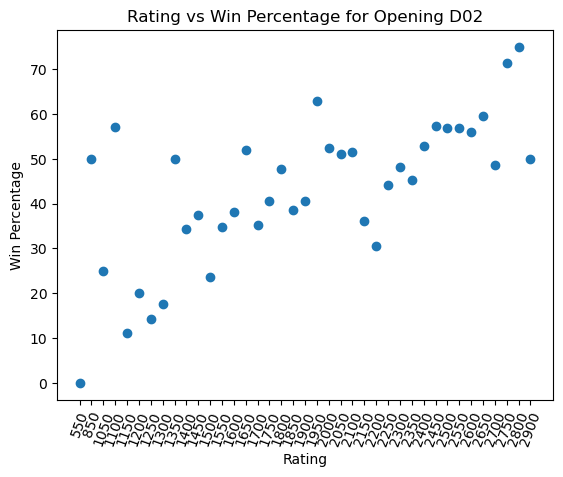

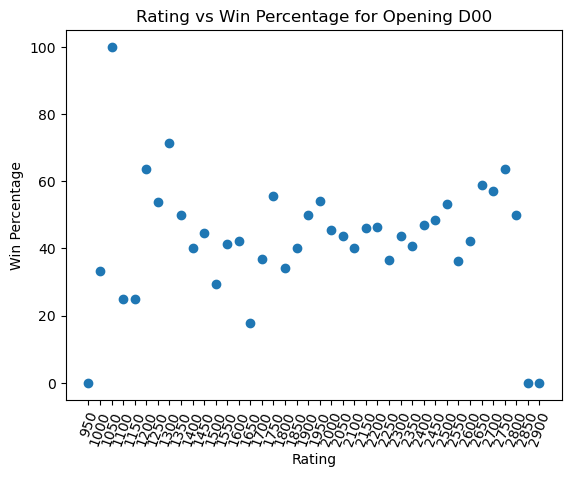

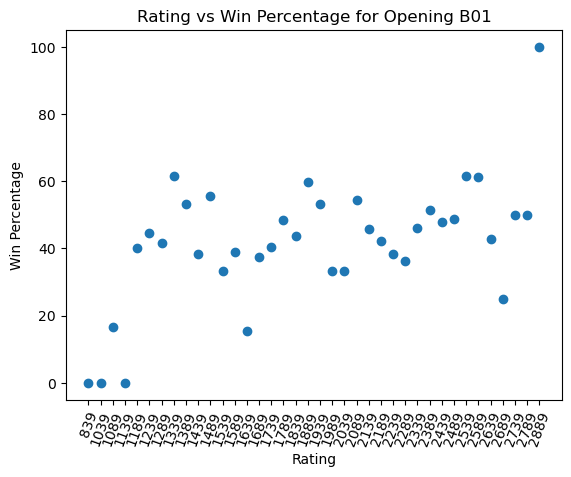

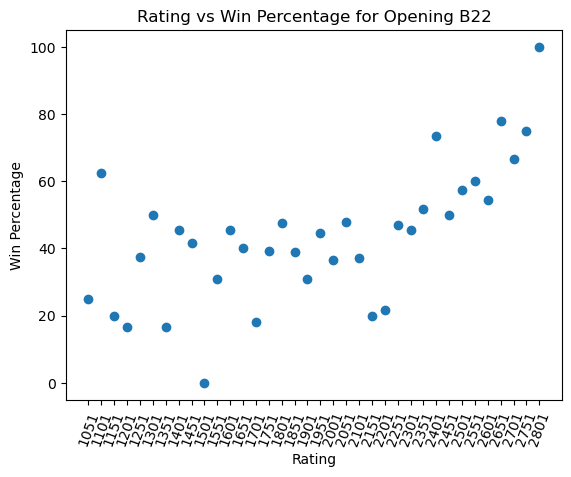

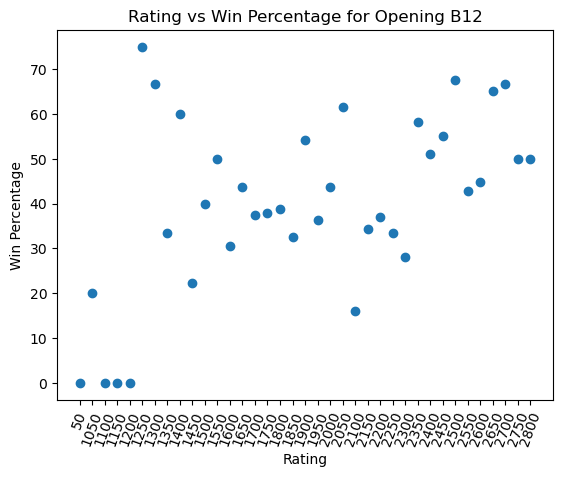

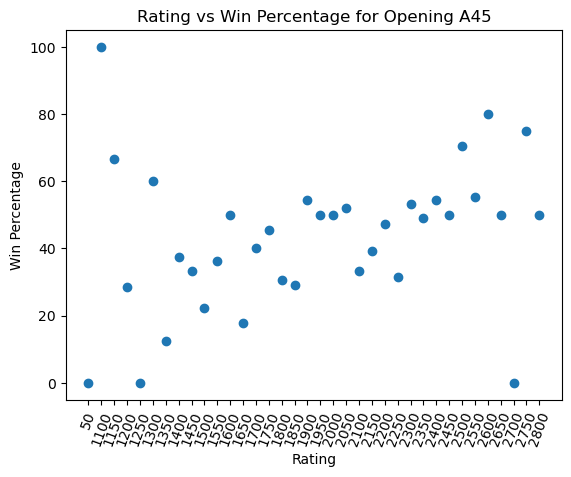

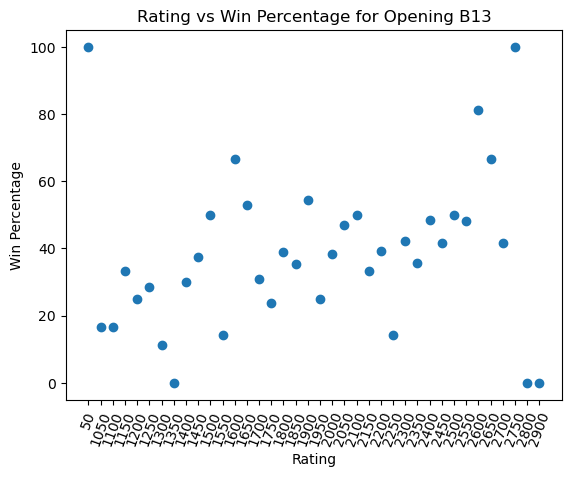

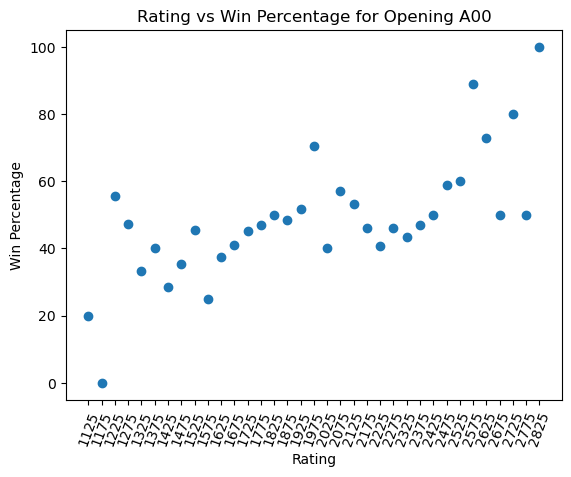

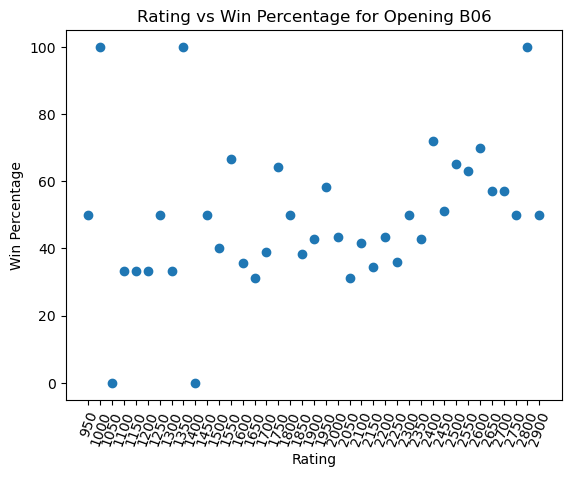

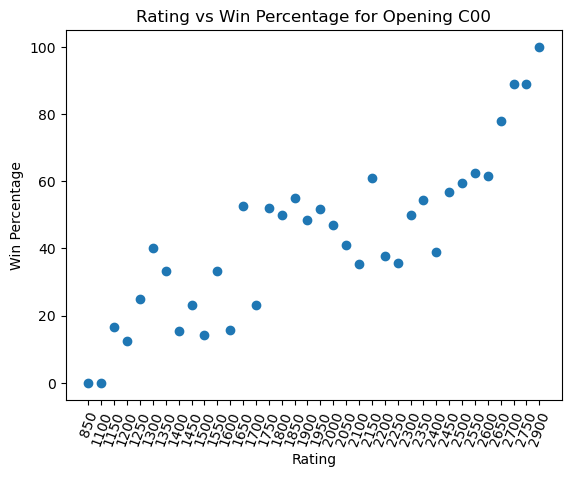

In [217]:
for opening in popular_eco_codes:
    plot_rating_vs_win_percentage(opening , processed_data)

In [218]:
def plot_moves_vs_win_percentage(opening, dataset):
    filtered_dataset = dataset[dataset['ECO'] == opening]
    move_counts = filtered_dataset['Move_Count']
    win_percentages = []

    # Define the move count ranges
    move_ranges = np.arange(0, max(move_counts) + 11, 10)

    for i in range(len(move_ranges) - 1):
        min_range = move_ranges[i]
        max_range = move_ranges[i+1]
        games_within_range = filtered_dataset[
            (filtered_dataset['Move_Count'] >= min_range) &
            (filtered_dataset['Move_Count'] < max_range)
        ]
        total_games = len(games_within_range)

        if total_games > 0:
            win_count = len(games_within_range[games_within_range['Outcome'] == '1-0'])
            win_percentage = (win_count / total_games) * 100
            win_percentages.append(win_percentage)
        else:
            win_percentages.append(0)  # Add a 0 win percentage for empty ranges

    # Check if there are win percentages to plot
    if len(win_percentages) > 0:
        # Plotting
        plt.bar(move_ranges[:-1], win_percentages, align='edge', width=10)
        plt.xlabel('Number of Moves Played')
        plt.ylabel('Win Percentage')
        plt.title(f'Number of Moves Played vs Win Percentage for Opening {opening}')
        plt.show()
    else:
        print(f"No data available for opening {opening}.")

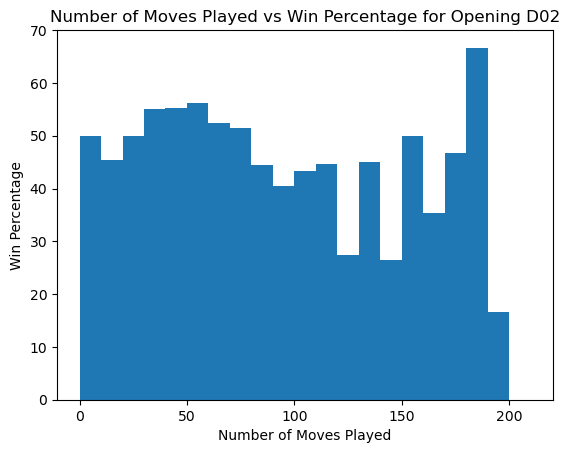

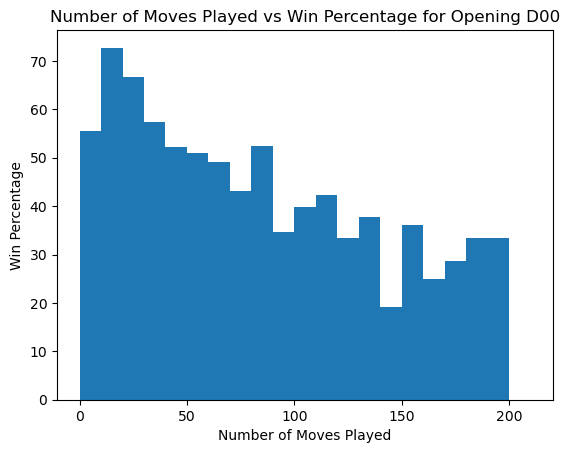

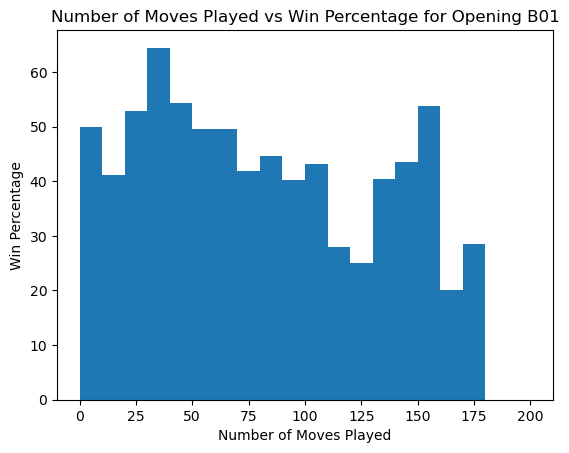

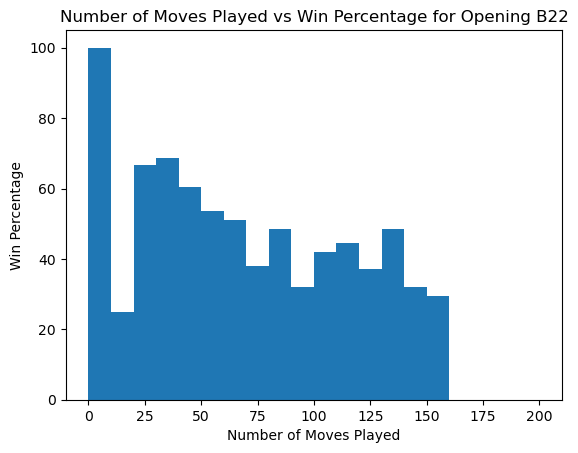

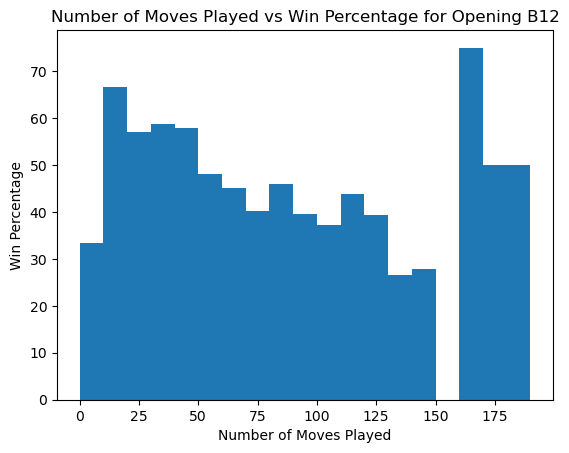

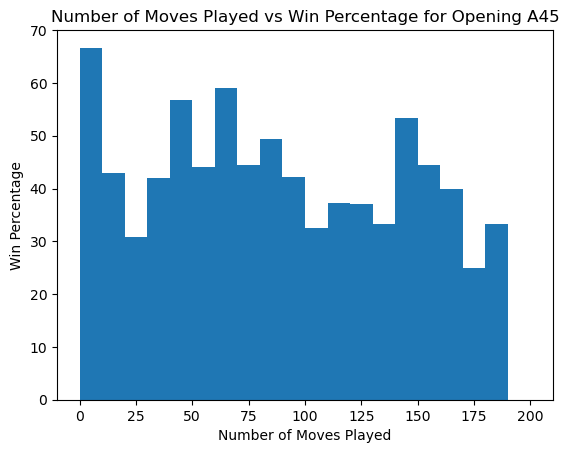

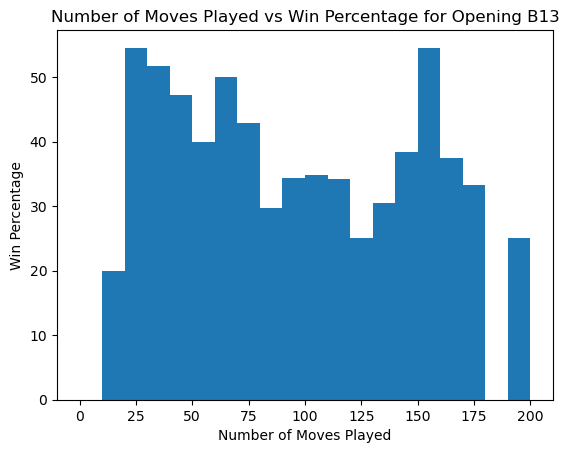

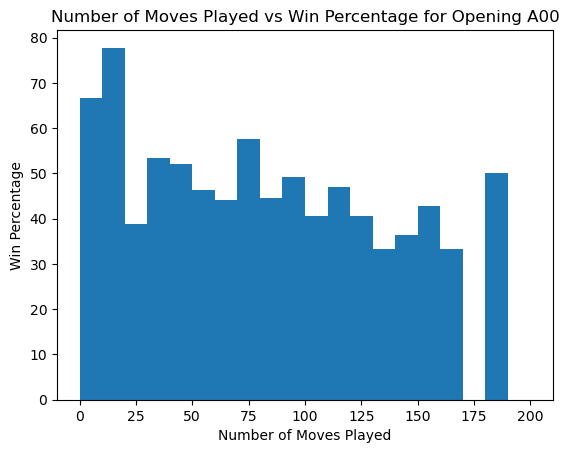

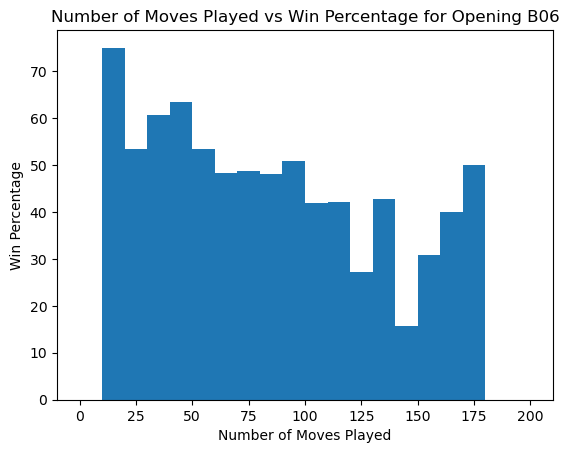

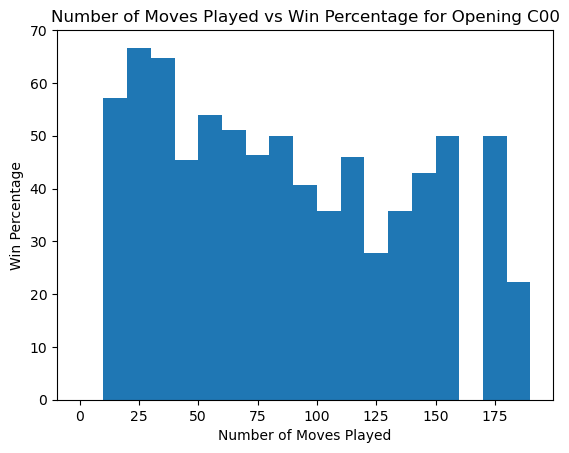

In [219]:
for opening in popular_eco_codes:
    plot_moves_vs_win_percentage(opening , processed_data)

In [282]:
print(processed_data)

       Elo_White  Elo_Black Outcome  ECO  \
2           1901       2126     1-0  E62   
3           2127       1881     1-0  A43   
4           1785       1971     0-1  E14   
5           2193       2026     1-0  C52   
6           1990       2061     0-1  B09   
...          ...        ...     ...  ...   
49860       1333       1305     1-0  C20   
49861       1358       1451     0-1  C50   
49862       1453       1425     0-1  C55   
49863       1322       1339     0-1  C23   
49864       1531       1500     1-0  C47   

                                                   Moves  Move_Count  
2      [g1f3, g8f6, c2c4, g7g6, g2g3, f8g7, f1g2, e8g...          93  
3      [d2d4, e7e6, c2c4, c7c5, d4d5, e6d5, c4d5, d7d...          51  
4      [d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, e2e3, c8b...          86  
5      [e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, b2b4, c5b...         109  
6      [e2e4, d7d6, d2d4, g8f6, b1c3, g7g6, f2f4, f8g...          62  
...                                          

In [283]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_variables(dataset):
    # Copy the original dataset to avoid modifying it directly
    encoded_dataset = dataset.copy()

    # Encode 'Outcome' column using label encoding
    label_encoder = LabelEncoder()
    encoded_dataset['Outcome'] = label_encoder.fit_transform(encoded_dataset['Outcome'])

    # Encode 'ECO' column using label encoding
    encoded_dataset['ECO'] = label_encoder.fit_transform(encoded_dataset['ECO'])

    return encoded_dataset


In [284]:
encoded_dataset = encode_categorical_variables(processed_data)
print(encoded_dataset)

       Elo_White  Elo_Black  Outcome  ECO  \
2           1901       2126        1  458   
3           2127       1881        1   43   
4           1785       1971        0  411   
5           2193       2026        1  252   
6           1990       2061        0  109   
...          ...        ...      ...  ...   
49860       1333       1305        1  220   
49861       1358       1451        0  250   
49862       1453       1425        0  255   
49863       1322       1339        0  223   
49864       1531       1500        1  247   

                                                   Moves  Move_Count  
2      [g1f3, g8f6, c2c4, g7g6, g2g3, f8g7, f1g2, e8g...          93  
3      [d2d4, e7e6, c2c4, c7c5, d4d5, e6d5, c4d5, d7d...          51  
4      [d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, e2e3, c8b...          86  
5      [e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, b2b4, c5b...         109  
6      [e2e4, d7d6, d2d4, g8f6, b1c3, g7g6, f2f4, f8g...          62  
...                              

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_matrix(dataset):
    # Calculate the correlation matrix
    correlation_matrix = dataset.corr()

    # Display the correlation matrix
    print(correlation_matrix)
    
    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

            Elo_White  Elo_Black   Outcome       ECO  Move_Count
Elo_White    1.000000   0.712534  0.174437  0.059037    0.107308
Elo_Black    0.712534   1.000000 -0.020775  0.036590    0.126633
Outcome      0.174437  -0.020775  1.000000  0.039894    0.074078
ECO          0.059037   0.036590  0.039894  1.000000    0.031419
Move_Count   0.107308   0.126633  0.074078  0.031419    1.000000


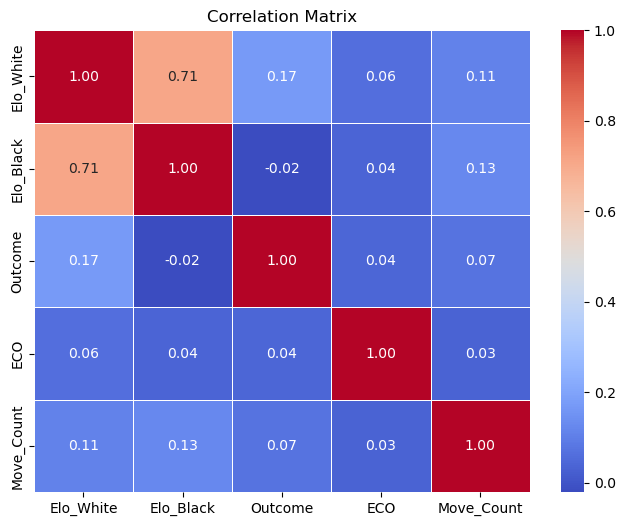

In [286]:
correlation_matrix(encoded_dataset)

In [287]:
def transform_dataset(dataset):
    dataset['Elo_Difference'] = dataset['Elo_White'] - dataset['Elo_Black']
    dataset = dataset.drop(columns=['Elo_White', 'Elo_Black'])
    return dataset

In [288]:
elo_diff_dataset = transform_dataset(encoded_dataset)

# Print the updated dataset
print(elo_diff_dataset)

       Outcome  ECO                                              Moves  \
2            1  458  [g1f3, g8f6, c2c4, g7g6, g2g3, f8g7, f1g2, e8g...   
3            1   43  [d2d4, e7e6, c2c4, c7c5, d4d5, e6d5, c4d5, d7d...   
4            0  411  [d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, e2e3, c8b...   
5            1  252  [e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, b2b4, c5b...   
6            0  109  [e2e4, d7d6, d2d4, g8f6, b1c3, g7g6, f2f4, f8g...   
...        ...  ...                                                ...   
49860        1  220  [e2e4, e7e5, d1h5, b8c6, f1b5, g7g6, h5f3, g8f...   
49861        0  250  [e2e4, e7e5, g1f3, b8c6, f1c4, h7h6, d2d4, g8f...   
49862        0  255  [e2e4, e7e5, g1f3, d7d6, f1c4, b8c6, d2d4, g8f...   
49863        0  223  [e2e4, e7e5, f1c4, b8c6, d2d3, g8f6, c1g5, h7h...   
49864        1  247  [e2e4, e7e5, g1f3, b8c6, b1c3, g8f6, d2d4, e5d...   

       Move_Count  Elo_Difference  
2              93            -225  
3              51             246  
4  

                 Outcome       ECO  Move_Count  Elo_Difference
Outcome         1.000000  0.039894    0.074078        0.257519
ECO             0.039894  1.000000    0.031419        0.029646
Move_Count      0.074078  0.031419    1.000000       -0.025387
Elo_Difference  0.257519  0.029646   -0.025387        1.000000


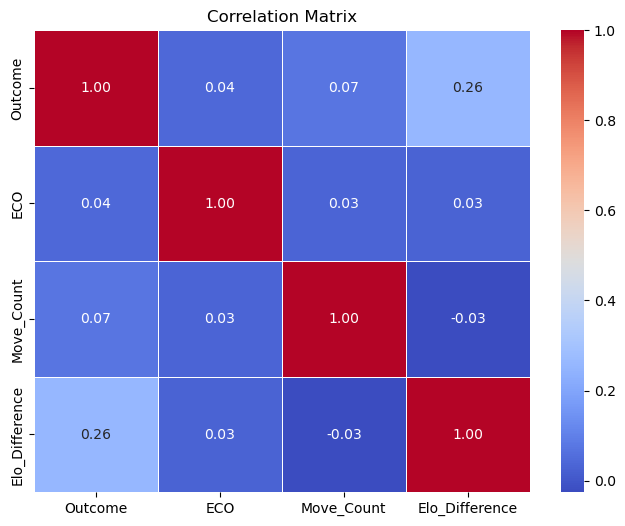

In [289]:
correlation_matrix(elo_diff_dataset)

In [290]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(dataset):
    # Extract the target variable
    y = dataset['Outcome']
    
    # Drop 'Moves' and 'Outcome' columns from the dataset
    X = dataset.drop(['Moves', 'Outcome'], axis=1)
    
    # Fill missing values with 0
    X = X.fillna(0)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the feature values
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test


In [291]:
from sklearn.linear_model import LogisticRegression

def train_model(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model


In [292]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report


In [293]:
X_train, X_test, y_train, y_test = preprocess_data(encoded_dataset)
print(X_train)

[[-0.8832674   0.26468367  1.03296834  0.43040816 -1.51212788]
 [-0.77393296 -0.82758487 -0.34822423 -1.35530804  0.06917041]
 [ 0.25172819 -0.48608802  0.20883134  2.15660048  0.97129937]
 ...
 [ 0.62658912  0.91118152  0.7964105   0.60897978 -0.3733187 ]
 [ 1.47523262  0.9268226   1.98683062 -0.04578283  0.7243287 ]
 [ 0.67084354  1.00242114  0.8116723   1.38279013 -0.43506137]]


In [294]:

# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data(encoded_dataset)

# Train the model
model = train_model(X_train, y_train)

# Evaluate the model
accuracy, report = evaluate_model(model, X_test, y_test)

# Display the results
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.5981327175986346
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      4084
           1       0.61      0.74      0.67      4680
           2       0.37      0.01      0.02      1197

    accuracy                           0.60      9961
   macro avg       0.52      0.45      0.43      9961
weighted avg       0.57      0.60      0.56      9961



In [295]:
print(accuracy)
print(report)
print(best)

0.5981327175986346
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      4084
           1       0.61      0.74      0.67      4680
           2       0.37      0.01      0.02      1197

    accuracy                           0.60      9961
   macro avg       0.52      0.45      0.43      9961
weighted avg       0.57      0.60      0.56      9961

{'C': 0.001, 'penalty': 'l2'}


In [296]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    labels = labels[:-1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the confusion matrix
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

[0 1 2]


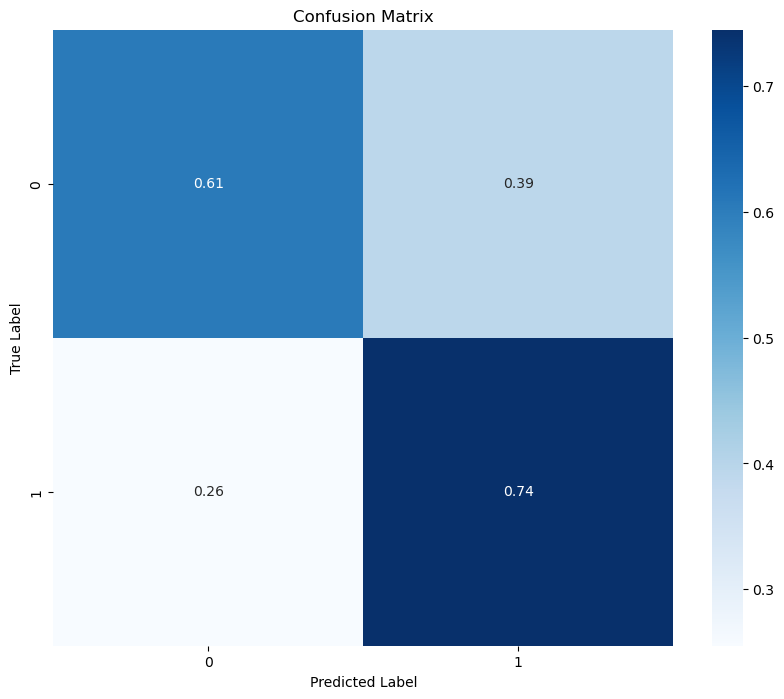

In [297]:
y_pred = model.predict(X_test)
unique_labels = np.unique(y_pred)
print(unique_labels)
display_confusion_matrix(y_test, y_pred)

In [302]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

def train_decision_tree(X_train, y_train):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_decision_tree(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data(encoded_dataset)

# Train the decision tree model
decision_tree_model = train_decision_tree(X_train, y_train)

# Evaluate the decision tree model
accuracy, report = evaluate_decision_tree(decision_tree_model, X_test, y_test)

# Display the results
print("Decision Tree Accuracy:", accuracy)
print("Decision Tree Classification Report:")
print(report)


Decision Tree Accuracy: 0.649834353980524
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      4084
           1       0.74      0.72      0.73      4680
           2       0.22      0.26      0.24      1197

    accuracy                           0.65      9961
   macro avg       0.55      0.55      0.55      9961
weighted avg       0.66      0.65      0.65      9961



[0 1 2]


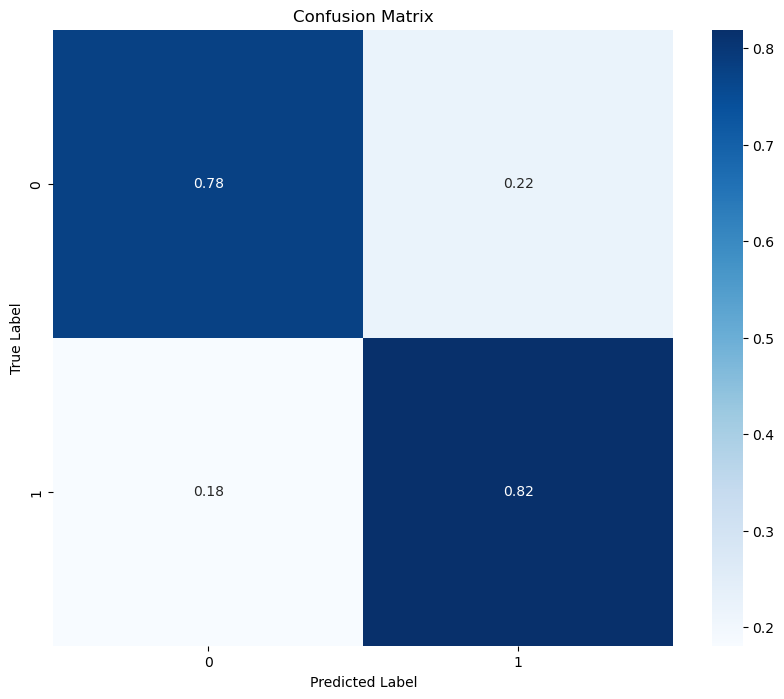

In [303]:
y_pred = decision_tree_model.predict(X_test)
unique_labels = np.unique(y_pred)
print(unique_labels)
display_confusion_matrix(y_test, y_pred)